# Feature Engineering

On the previous notebook we have cleaned a data set of all matches and we ended up with dataset where each observation is a match and it has all the stats from that the match: 'home_team_goal','away_team_goal','possesion_home', 'possesion_away', 'shoton_home', 'shoton_away', 'shotoff_home', 'shotoff_away', 'foul_home', 'foul_away', 'cross_home', 'cross_away', 'corner_home', 'corner_away','cards_home_yellow', 'cards_home_red', 'cards_away_yellow','cards_away_red'.

The idea is to generate a new dataset for each match that has as variables a weighted average (gets small the further in the past) of the last 5 matches of both teams. For intance, the home team will have a weigthed avg of its stats in the last 5 games it played at home and the away team will have a weighted avg of its last 5 games it played away. I only count games of the same season because teams change considerably from season to season. The downside of this is that we cannot compute the stats for the first 10 games of the season (if we are taking 5 games back).

The intuition behind this is that each team performs differently when they play away or at home and from season to season.

In this notebook we'll:

* Generate new features: result (taget variable), goal_diff
* Select leagues with enough matches to compute the avg
* Compute stasts
* Predict

In [1]:
%matplotlib inline

#imports
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from pandas.tools.plotting import scatter_matrix

In [2]:
# load cleaned t
laliga = pd.read_csv(".\\data_processed\\laliga.csv")
print(laliga.shape)
laliga.head()

(8419, 23)


,league_id,season,stage,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,possesion_home,possesion_away,shoton_home,...,foul_home,foul_away,cross_home,cross_away,corner_home,corner_away,cards_home_yellow,cards_home_red,cards_away_yellow,cards_away_red
0,1729,2008/2009,1,10260,10261,1,1,55,45,11,...,16,11,24,9,6,6,3,0,0,0
1,1729,2008/2009,1,9825,8659,1,0,66,34,12,...,11,9,21,7,7,5,0,0,0,0
2,1729,2008/2009,1,8472,8650,0,1,46,54,4,...,13,12,15,19,1,8,0,0,2,0
3,1729,2008/2009,1,8654,8528,2,1,52,48,5,...,14,13,15,27,6,10,2,0,1,0
4,1729,2008/2009,1,10252,8456,4,2,52,48,5,...,11,13,16,16,7,8,0,0,1,0


In [3]:
# matches per league, we will need at least 300
laliga.league_id.value_counts()

1729     3035
21518    1628
10257    1534
7809     1119
4769      764
13274     319
19694      13
15722       7
Name: league_id, dtype: int64

In [4]:
# generate new features

# Compute target variable
def who_won (row):
    if row['home_team_goal'] > row['away_team_goal']:
        return 1
    elif row['home_team_goal'] < row['away_team_goal']:
        return 2
    else:
        return 0

laliga['result'] = laliga.apply(who_won, axis=1)

# create goal diff
laliga["goal_diff"] = laliga['home_team_goal'] - laliga['away_team_goal']

In [5]:
# funtions to generate new features for home and away (weighted avg)


def stat(dataset, team_api_id, schedule, stat, weight=2, lag=5):
    
    # selects stat column by schedule (home or away)
    if schedule == 'home':
        stat_series = dataset.loc[dataset["home_team_api_id"]==team_api_id,stat]
    elif schedule == 'away':
        stat_series = dataset.loc[dataset["away_team_api_id"]==team_api_id,stat]
    
    stat_series = stat_series.iloc[-lag:].tolist()
    stat_series.reverse()
    stat_weighted = stat_series.pop(0)
    
    for s in stat_series:
        stat_weighted += s/weight
        weight *= weight
   
    return stat_weighted


def stats_league(laliga):
    # generates new avg features for home and away. Change parameters for weights and # of matches bellow
    w = 2 #weight
    l = 5 #lag
    
    laliga_ml = pd.DataFrame()

    for index, row in laliga.iterrows():
        if row['stage'] > 10:

            stage = row['stage']
            laliga_trim = laliga.loc[laliga['stage']< stage]

            hometeam = row['home_team_api_id']
            awayteam = row['away_team_api_id']

            laliga_ml_aux = pd.DataFrame()

            laliga_ml_aux['stage'] = [stage]
            laliga_ml_aux['home_team_goal'] = [stat(laliga_trim, hometeam, 'home', 'home_team_goal', weight=w, lag=l)]
            laliga_ml_aux['away_team_goal'] = [stat(laliga_trim, hometeam, 'away', 'home_team_goal', weight=w, lag=l)]
            laliga_ml_aux['possesion_home'] = [stat(laliga_trim, hometeam, 'home', 'possesion_home', weight=w, lag=l)]
            laliga_ml_aux['possesion_away'] = [stat(laliga_trim, hometeam, 'away', 'possesion_away', weight=w, lag=l)]
            laliga_ml_aux['shoton_home'] = [stat(laliga_trim, hometeam, 'home', 'shoton_home', weight=w, lag=l)]
            laliga_ml_aux['shoton_away'] = [stat(laliga_trim, hometeam, 'away', 'shoton_away', weight=w, lag=l)]
            laliga_ml_aux['shotoff_home'] = [stat(laliga_trim, hometeam, 'home', 'shotoff_home', weight=w, lag=l)]
            laliga_ml_aux['shotoff_away'] = [stat(laliga_trim, hometeam, 'away', 'shotoff_away', weight=w, lag=l)]
            laliga_ml_aux['foul_home'] = [stat(laliga_trim, hometeam, 'home', 'foul_home', weight=w, lag=l)]
            laliga_ml_aux['foul_away'] = [stat(laliga_trim, hometeam, 'away', 'foul_away', weight=w, lag=l)]
            laliga_ml_aux['cross_home'] = [stat(laliga_trim, hometeam, 'home', 'cross_home', weight=w, lag=l)]
            laliga_ml_aux['cross_away'] = [stat(laliga_trim, hometeam, 'away', 'cross_away', weight=w, lag=l)]
            laliga_ml_aux['corner_home'] = [stat(laliga_trim, hometeam, 'home', 'corner_home', weight=w, lag=l)]
            laliga_ml_aux['corner_away'] = [stat(laliga_trim, hometeam, 'away', 'corner_away', weight=w, lag=l)]
            laliga_ml_aux['cards_home_yellow'] = [stat(laliga_trim, hometeam, 'home', 'cards_home_yellow', weight=w, lag=l)]
            laliga_ml_aux['cards_home_red'] = [stat(laliga_trim, hometeam, 'home', 'cards_home_red', weight=w, lag=l)]
            laliga_ml_aux['cards_away_yellow'] = [stat(laliga_trim, hometeam, 'away', 'cards_away_yellow', weight=w, lag=l)]
            laliga_ml_aux['cards_away_red'] = [stat(laliga_trim, hometeam, 'away', 'cards_away_red', weight=w, lag=l)]
            laliga_ml_aux['goal_diff_home'] = [stat(laliga_trim, hometeam, 'home', 'goal_diff', weight=w, lag=l)] 
            laliga_ml_aux['goal_diff_away'] = [-x for x in ([stat(laliga_trim, hometeam, 'away', 'goal_diff', weight=w, lag=l)])]
            laliga_ml_aux['result'] = [row['result']]
            laliga_ml_aux['league_id'] = [row['league_id']]

            laliga_ml = pd.concat([laliga_ml,laliga_ml_aux])

    laliga_ml.reset_index(drop=True, inplace=True)
    return laliga_ml

Divide by league to get new variables

In [6]:
# get rid of seasons with less than 300 matches
laliga_list = []
for league in laliga.league_id.unique():
    #print(league)
    #print(laliga[laliga['league_id'] == league].season.value_counts())
    seasons= laliga[laliga['league_id'] == league].season.value_counts()
    #print(seasons[seasons>300])
    for s in seasons[seasons>300].index:
        #print(s)
        laliga_list.append(laliga[(laliga['league_id'] == league) & (laliga['season'] == s)])

In [7]:
#calculate new stats for each league and ...
laliga_ml = []
for league in laliga_list:
    laliga_ml.append(stats_league(league))

In [8]:
# ... join them back together
laliga_ml = pd.concat(laliga_ml, ignore_index=True)
print(laliga_ml.shape)
print(laliga_ml['league_id'].value_counts())
print(laliga.columns)
laliga_ml.head(20)

(4566, 23)
1729     2239
4769      560
21518     560
10257     559
7809      432
13274     216
Name: league_id, dtype: int64
Index(['league_id', 'season', 'stage', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal', 'away_team_goal', 'possesion_home', 'possesion_away',
       'shoton_home', 'shoton_away', 'shotoff_home', 'shotoff_away',
       'foul_home', 'foul_away', 'cross_home', 'cross_away', 'corner_home',
       'corner_away', 'cards_home_yellow', 'cards_home_red',
       'cards_away_yellow', 'cards_away_red', 'result', 'goal_diff'],
      dtype='object')


,stage,home_team_goal,away_team_goal,possesion_home,possesion_away,shoton_home,shoton_away,shotoff_home,shotoff_away,foul_home,...,corner_home,corner_away,cards_home_yellow,cards_home_red,cards_away_yellow,cards_away_red,goal_diff_home,goal_diff_away,result,league_id
0,11,3.070312,4.195312,98.207031,111.902344,13.089844,8.707031,8.140625,17.207031,32.621094,...,7.703125,14.828125,2.816406,0.003906,3.398438,0.250000,1.437500,-0.941406,2,1729
1,11,2.128906,0.816406,81.535156,78.394531,12.085938,13.335938,5.386719,8.941406,20.117188,...,6.398438,8.390625,4.191406,0.000000,5.312500,0.000000,-1.191406,0.695312,0,1729
2,11,1.257812,2.007812,84.824219,95.984375,16.765625,10.832031,10.457031,8.890625,20.339844,...,9.781250,7.082031,4.003906,0.000000,4.378906,0.500000,-2.625000,1.183594,1,1729
3,11,8.386719,4.000000,108.941406,99.011719,15.535156,23.230469,11.527344,14.011719,20.636719,...,8.582031,13.023438,3.828125,0.000000,3.378906,0.000000,6.386719,-1.988281,1,1729
4,11,7.257812,7.136719,78.343750,76.550781,7.015625,8.925781,5.324219,4.898438,19.535156,...,6.273438,8.039062,2.132812,0.062500,2.632812,0.003906,3.687500,-6.136719,0,1729
5,11,4.187500,1.070312,86.339844,88.421875,8.910156,13.519531,11.523438,7.281250,26.800781,...,9.660156,9.460938,4.015625,0.000000,5.578125,0.000000,0.925781,2.000000,1,1729
6,11,1.132812,3.820312,90.761719,106.183594,9.222656,13.238281,12.777344,8.570312,13.417969,...,4.015625,5.906250,3.132812,0.000000,2.199219,0.000000,-0.929688,-2.437500,2,1729
7,11,2.257812,2.316406,90.328125,103.378906,15.039062,20.460938,8.949219,12.632812,27.128906,...,12.390625,12.070312,4.007812,0.000000,5.574219,0.000000,1.750000,0.746094,1,1729
8,11,0.250000,2.007812,74.191406,79.191406,9.914062,8.960938,10.402344,9.074219,22.988281,...,6.570312,6.570312,4.253906,0.250000,2.570312,0.000000,-3.250000,0.125000,1,1729
9,11,2.125000,2.000000,91.628906,75.089844,6.394531,9.574219,7.644531,5.507812,19.359375,...,5.523438,8.011719,2.390625,0.000000,5.632812,0.000000,0.425781,-1.246094,2,1729


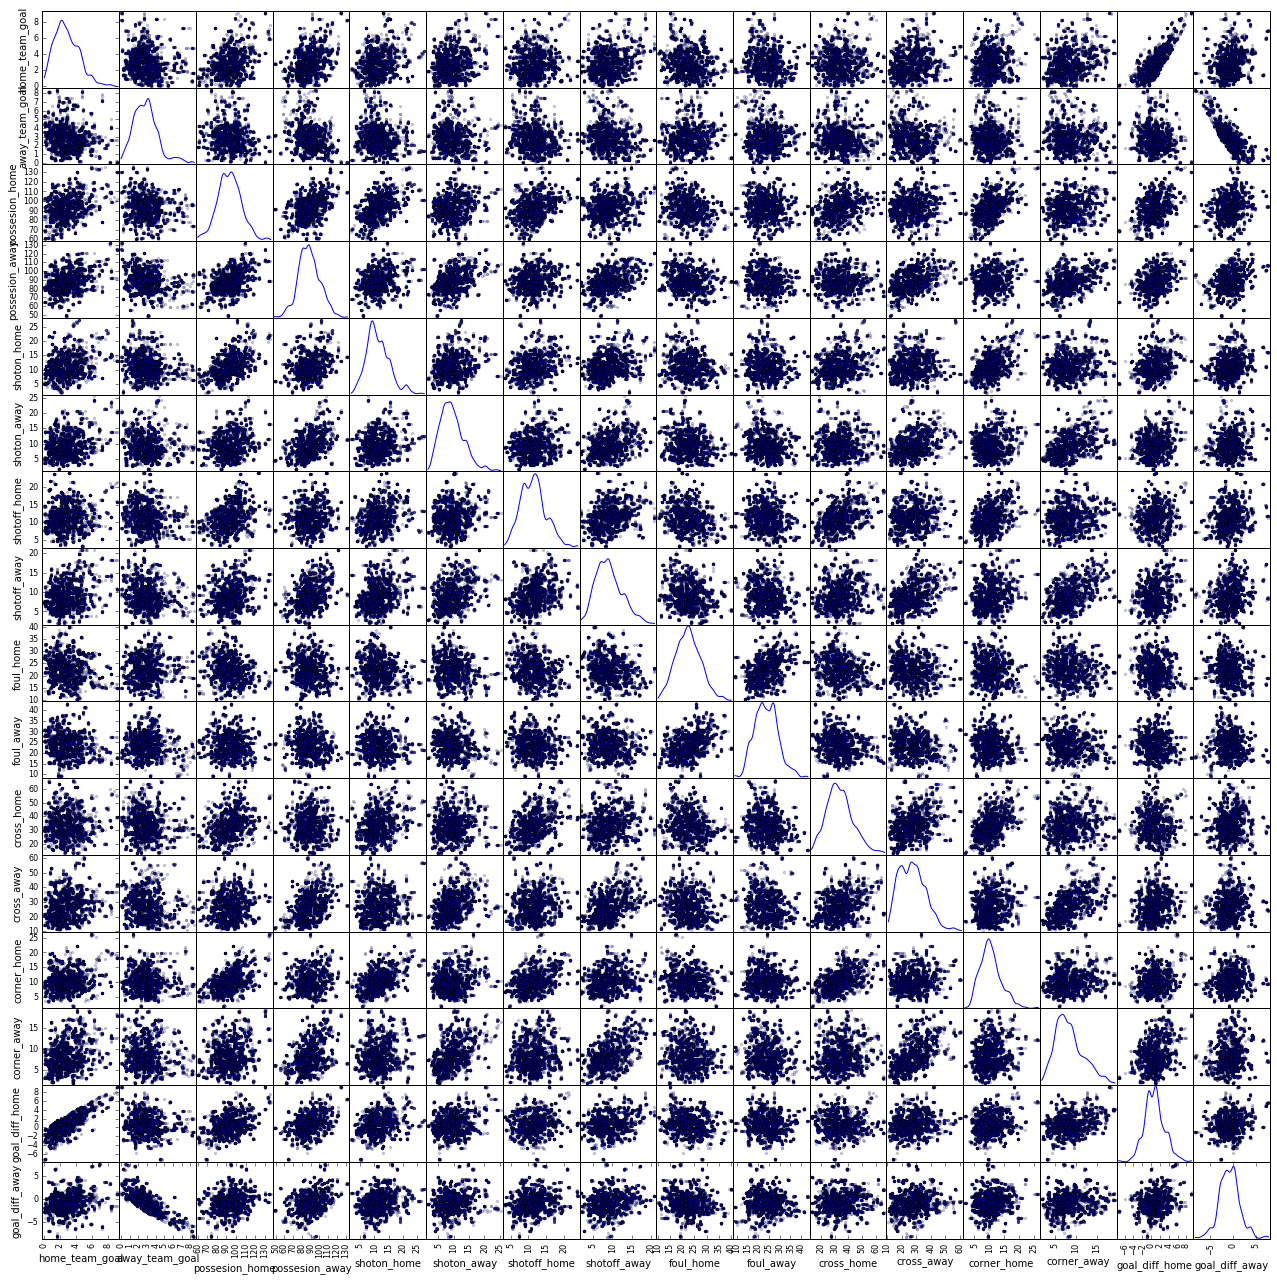

In [9]:
# columns scatter plots (no cards)
columns = ['home_team_goal', 'away_team_goal', 'possesion_home', 'possesion_away',
           'shoton_home', 'shoton_away', 'shotoff_home', 'shotoff_away',
           'foul_home', 'foul_away', 'cross_home', 'cross_away', 'corner_home',
           'corner_away','goal_diff_home','goal_diff_away']
pd.tools.plotting.scatter_matrix(laliga_ml[columns], alpha=0.2, figsize=(22, 22), diagonal='kde')
plt.show()

## create goal diff

## Create varialble to predict, who won? (TIE[0], HOME[1], AWAY[2]):

In [25]:
#NO CARDS
columns = ['home_team_goal', 'away_team_goal', 'possesion_home', 'possesion_away',
          'shoton_home', 'shoton_away', 'shotoff_home', 'shotoff_away',
          'foul_home', 'foul_away', 'cross_home', 'cross_away', 'corner_home',
          'corner_away','goal_diff_home','goal_diff_away']

In [30]:
#CARDS
columns = ['home_team_goal', 'away_team_goal', 'possesion_home', 'possesion_away',
           'shoton_home', 'shoton_away', 'shotoff_home', 'shotoff_away',
           'foul_home', 'foul_away', 'cross_home', 'cross_away', 'corner_home',
           'corner_away', 'cards_home_yellow', 'cards_home_red',
           'cards_away_yellow', 'cards_away_red','goal_diff_home','goal_diff_away']


In [31]:
#train and test (Spanish leach last season 2016)
X_train = laliga_ml.loc[laliga_ml['league_id']!=21518,columns]
y_train = laliga_ml.loc[laliga_ml['league_id']!=21518,'result']

X_test = laliga_ml.loc[laliga_ml['league_id']==21518,columns]
y_test = laliga_ml.loc[laliga_ml['league_id']==21518,'result']

In [32]:
#Random forest
#penalty = {0:1, 1:5, 2:2}
rfsel = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, class_weight='balanced',random_state=2)
rfsel.fit(X_train, y_train)
features_lb = sorted(zip(map(lambda x: round(x, 4), rfsel.feature_importances_), X_train.columns), reverse=True, key=lambda pair: pair[0])
features_lb

[(0.062300000000000001, 'possesion_home'),
 (0.060100000000000001, 'possesion_away'),
 (0.059700000000000003, 'cross_home'),
 (0.0596, 'foul_home'),
 (0.0579, 'shoton_home'),
 (0.057299999999999997, 'shotoff_home'),
 (0.057299999999999997, 'corner_home'),
 (0.055, 'cross_away'),
 (0.054699999999999999, 'goal_diff_home'),
 (0.054399999999999997, 'goal_diff_away'),
 (0.054300000000000001, 'home_team_goal'),
 (0.053800000000000001, 'shotoff_away'),
 (0.0521, 'foul_away'),
 (0.050900000000000001, 'shoton_away'),
 (0.050700000000000002, 'corner_away'),
 (0.049799999999999997, 'cards_home_yellow'),
 (0.046800000000000001, 'away_team_goal'),
 (0.0465, 'cards_away_yellow'),
 (0.0085000000000000006, 'cards_away_red'),
 (0.0082000000000000007, 'cards_home_red')]

In [33]:
# Accuracy
predictions = rfsel.predict(X_test)
(predictions == y_test).sum()/len(y_test)

0.49107142857142855

In [36]:
# SUMMARY
preds = pd.DataFrame()
preds["results"] = y_test
preds["predictions"] = rfsel.predict(X_test)
print("My predictions")
print(preds["predictions"].value_counts(),"\n\n")
print("Home 1:")
print(len(preds[(preds["predictions"]==1) & (preds["results"]==1)])/sum(preds["results"]==1),'% Accuracy')
print(len(preds[(preds["predictions"]==1) & (preds["results"]==1)]), "/", sum(preds["results"]==1))
print("I didn't say 1 but it was 1:" , len(preds[(preds["predictions"]!=1) & (preds["results"]==1)]),)
print("I said 1 but it wasn't 1   :" , len(preds[(preds["predictions"]==1) & (preds["results"]!=1)]),"\n")
print("Away 2")
print(len(preds[(preds["predictions"]==2) & (preds["results"]==2)])/sum(preds["results"]==2),'% Accuracy')
print(len(preds[(preds["predictions"]==2) & (preds["results"]==2)]), "/", sum(preds["results"]==2))
print("Wrong:" , len(preds[(preds["predictions"]!=2) & (preds["results"]==2)]),"\n")
print("Tie 0")
print(len(preds[(preds["predictions"]==0) & (preds["results"]==0)])/sum(preds["results"]==0),'% Accuracy')
print(len(preds[(preds["predictions"]==0) & (preds["results"]==0)]), "/", sum(preds["results"]==0))
print("Wrong:" , len(preds[(preds["predictions"]!=0) & (preds["results"]==0)]))

My predictions
1    481
2     59
0     20
Name: predictions, dtype: int64 


Home 1:
0.899628252788 % Accuracy
242 / 269
I didn't say 1 but it was 1: 27
I said 1 but it wasn't 1   : 239 

Away 2
0.164556962025 % Accuracy
26 / 158
Wrong: 132 

Tie 0
0.0526315789474 % Accuracy
7 / 133
Wrong: 126


In [17]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,predictions)


TODO:

* fix code and comments!!
* add goal difference
* other models
* feature selection
* validation set?cv
* different lags and weights

In [ ]:
from sklearn import pipeline, grid_search
rffc = RandomForestClassifier(n_jobs=-1, random_state=20, min_samples_leaf= , criterion='gini')
param_grid = {'n_estimators':[100,300],'min_samples_leaf': [1,2,50]}
rffc_gs = grid_search.GridSearchCV(estimator = rffc, param_grid = param_grid, cv = 20, n_jobs=-1, scoring='accuracy', error_score=0, verbose=2) 
rffc_gs_fit = rffc_gs.fit(X_train, y_train)
print("Best parameters found by grid search:", rffc_gs.best_params_)
print("Best CV score:", rffc_gs.best_score_)